### 데이터 불러오기

In [55]:
# 매크로 데이터 불러오기
import pandas as pd

macro = pd.read_csv("macro.csv", index_col = 0)
macro["date"] = pd.to_datetime(macro["date"])
macro.head()

,date,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2005-02-01,47.12,12.03,0.736,9.9161,1028.50,56.8,54.7
1,2005-02-02,46.69,11.66,0.706,9.9151,1027.85,56.8,54.7
2,2005-02-03,46.45,11.79,0.697,9.8172,1025.50,56.8,54.7
3,2005-02-04,46.48,11.21,0.661,9.8319,1023.50,56.8,54.7
4,2005-02-07,45.28,11.73,0.627,9.8169,1029.50,56.8,54.7


In [56]:
# ETF 데이터
import FinanceDataReader as fdr

wti_etf = fdr.DataReader("130680", "2010-01-01")
wti_etf = wti_etf.reset_index()
wti_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
wti_etf.head()

,date,open,high,low,close,volume,change
0,2010-08-02,10020,10025,9935,9955,22278,NaN
1,2010-08-03,10140,10170,10120,10150,15684,0.019588
2,2010-08-04,10250,10310,10240,10245,2128,0.009360
3,2010-08-05,10300,10300,10240,10250,887,0.000488
4,2010-08-06,10265,10265,10200,10235,3278,-0.001463


### 기술 지표 데이터 산출

In [57]:
# true range

high_low = []
high_close = []
low_close = []

for i in range(0, len(wti_etf)):
    
    # |당일 고가 - 당일 저가|
    today_high = wti_etf["high"][i]
    today_low = wti_etf["low"][i]
    val_high_low = abs(today_high - today_low)
    high_low.append(val_high_low)
    
    # |당일 고가 - 전일 종가|
    if i - 1 == -1:
        recent_close = wti_etf["close"][i]
    
    else:
        recent_close = wti_etf["close"][i - 1]
        
    val_high_close = abs(today_high - recent_close)
    high_close.append(val_high_close)
    
    # |당일 저가 - 전일 종가|
    val_low_close = abs(today_low - recent_close)
    low_close.append(val_low_close)
    
true_range = []

for j in range(0, len(wti_etf)):
    tr_val = max(high_low[j], high_close[j], low_close[j])
    true_range.append(tr_val)
    
wti_etf["true_range"] = true_range

In [58]:
# nomalized average true range
import numpy as np

natr = []

for i in range(0, len(wti_etf)):
    if i + 1 < 14:
        natr_val = np.nan
    
    else:
        natr_val = wti_etf["true_range"][i-13:i+1].sum() / wti_etf["close"][i] * 100
        
    natr.append(natr_val)
    
wti_etf["NATR"] = natr

In [59]:
# moving average (5, 15, 30)

ma5 = []

for i in range(0, len(wti_etf)):
    if i + 1 < 5:
        ma5_val = np.nan
        
    else:
        ma5_val = wti_etf["close"][i-4:i+1].sum() / 5
        
    ma5.append(ma5_val)
    
ma15 = []

for j in range(0, len(wti_etf)):
    if j + 1 < 15:
        ma15_val = np.nan
        
    else:
        ma15_val = wti_etf["close"][j-14:j+1].sum() / 15
        
    ma15.append(ma15_val)
    
ma30 = []

for k in range(0, len(wti_etf)):
    if k + 1 < 30:
        ma30_val = np.nan
        
    else:
        ma30_val = wti_etf["close"][k-29:k+1].sum() / 30
        
    ma30.append(ma30_val)
    
wti_etf["MA5"] = ma5
wti_etf["MA15"] = ma15
wti_etf["MA30"] = ma30

In [60]:
# bollinger band (upper, middle, lower band, band width)

middle_band = []

for i in range(0, len(wti_etf)):
    if i + 1 < 20:
        middle = np.nan
        
    else:
        middle = wti_etf["close"][i-19:i+1].sum() / 20
        
    middle_band.append(middle)
    
upper_band = []
lower_band = []

for j in range(0, len(wti_etf)):
    if j + 1 < 20:
        upper = np.nan
        lower = np.nan
        
    else:
        upper = middle_band[j] + (2 * wti_etf["close"][j-19:j+1].std())
        lower = middle_band[j] - (2 * wti_etf["close"][j-19:j+1].std())
        
    upper_band.append(upper)
    lower_band.append(lower)
    
wti_etf["upper_band"] = upper_band
wti_etf["middle_band"] = middle_band
wti_etf["lower_band"] = lower_band
wti_etf["band_width"] = wti_etf["upper_band"] - wti_etf["lower_band"]

In [61]:
# on balance volume

obv = []

for i in range(0, len(wti_etf)):
    if i - 1 == -1:
        obv_val = wti_etf["volume"][i]
        
    else:
        if wti_etf["close"][i] > wti_etf["close"][i-1]:
            obv_val = obv_val + wti_etf["volume"][i]
        
        else:
            obv_val = obv_val - wti_etf["volume"][i]
            
    obv.append(obv_val)
    
wti_etf["OBV"] = obv

In [62]:
# 5 days momentun, 20 days momentum (영업일 기준)
wti_etf["close_5lag"] = wti_etf["close"].shift(5)
wti_etf["momentum_5"] = (wti_etf["close"] - wti_etf["close_5lag"]) / wti_etf["close_5lag"]

wti_etf["close_20lag"] = wti_etf["close"].shift(20)
wti_etf["momentum_20"] = (wti_etf["close"] - wti_etf["close_20lag"]) / wti_etf["close_20lag"]

In [63]:
# MACD

def fnMACD(m_Df, m_NumFast=12, m_NumSlow=26, m_NumSignal=9):
    test = pd.DataFrame()
    test['EMAFast'] = m_Df['close'].ewm( span = m_NumFast, min_periods = m_NumFast - 1).mean()
    test['EMASlow'] = m_Df['close'].ewm( span = m_NumSlow, min_periods = m_NumSlow - 1).mean()
    test['MACD'] = test['EMAFast'] - test['EMASlow']
    test['MACDSignal'] = test['MACD'].ewm( span = m_NumSignal, min_periods = m_NumSignal-1).mean()
    test['MACDDiff'] = test['MACD'] - test['MACDSignal']
    
    m_Df["MACD"] = test["MACD"]
    m_Df["MACDDiff"] = test["MACDDiff"]
    return m_Df

wti_etf = fnMACD(wti_etf)

In [64]:
# RSI

def SMA(data, period = 30, columns = "close"):
    return data[columns].rolling(window = period).mean()

def EMA(data, period = 20, columns = "close"):
    return data[columns].ewm(span = period, adjust = False).mean()

def RSI(data, period = 14, columns = "close"):
    delta = data[columns].diff(1)
    delta = delta.dropna()
    
    up = delta.copy()
    down = delta.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    data["up"] = up
    data["down"] = down
    
    AVG_Gain = SMA(data, period, columns = "up")
    AVG_Loss = abs(SMA(data, period, columns = "down"))
    RS = AVG_Gain / AVG_Loss
    
    RSI = 100.0 - (100.0 / (1.0 + RS))
    data["RSI"] = RSI
    
    data = data.drop(["up", "down"], axis = 1)
    
    return data

wti_etf = RSI(wti_etf, 14)

In [65]:
# target 생성
def target(x):
    if x > 0:
        return 1
    
    elif x <= 0:
        return 0
    
wti_etf["close_-20lag"] = wti_etf["close"].shift(-20)
wti_etf["return"] = (wti_etf["close_-20lag"] - wti_etf["close"]) / wti_etf["close"]
wti_etf["grade"] = wti_etf["return"].apply(target)

wti_etf.head()

,date,open,high,low,close,volume,change,true_range,NATR,MA5,...,close_5lag,momentum_5,close_20lag,momentum_20,MACD,MACDDiff,RSI,close_-20lag,return,grade
0,2010-08-02,10020,10025,9935,9955,22278,NaN,90,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9755.0,-0.020090,0.0
1,2010-08-03,10140,10170,10120,10150,15684,0.019588,215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9700.0,-0.044335,0.0
2,2010-08-04,10250,10310,10240,10245,2128,0.009360,160,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9525.0,-0.070278,0.0
3,2010-08-05,10300,10300,10240,10250,887,0.000488,60,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9605.0,-0.062927,0.0
4,2010-08-06,10265,10265,10200,10235,3278,-0.001463,65,NaN,10167.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9610.0,-0.061065,0.0


In [66]:
# wti_etf과 macro date merge
wti_etf = pd.merge(wti_etf, macro, on = "date", how = "inner").reset_index(drop = True)
wti_etf.head()

,date,open,high,low,close,volume,change,true_range,NATR,MA5,...,close_-20lag,return,grade,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2010-08-02,10020,10025,9935,9955,22278,NaN,90,NaN,NaN,...,9755.0,-0.020090,0.0,81.34,22.01,2.116,13.5673,1173.50,55.5,51.2
1,2010-08-03,10140,10170,10120,10150,15684,0.019588,215,NaN,NaN,...,9700.0,-0.044335,0.0,82.55,22.63,2.127,13.6178,1168.20,55.5,51.2
2,2010-08-04,10250,10310,10240,10245,2128,0.009360,160,NaN,NaN,...,9525.0,-0.070278,0.0,82.47,22.21,2.115,13.5268,1167.50,55.5,51.2
3,2010-08-05,10300,10300,10240,10250,887,0.000488,60,NaN,NaN,...,9605.0,-0.062927,0.0,82.01,22.10,2.108,13.6028,1167.25,55.5,51.2
4,2010-08-06,10265,10265,10200,10235,3278,-0.001463,65,NaN,10167.0,...,9610.0,-0.061065,0.0,80.70,21.74,2.068,13.5832,1161.50,55.5,51.2


In [67]:
# 필요한 칼럼만 추출
wti_etf_f = wti_etf[["date", "volume", "NATR", "momentum_5", "momentum_20", "diff", "ism", "vix", "jpy_krw", "usd_krw", "china_pmi", "grade"]]
wti_etf_f.head()

,date,volume,NATR,momentum_5,momentum_20,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-08-02,22278,NaN,NaN,NaN,2.116,55.5,22.01,13.5673,1173.50,51.2,0.0
1,2010-08-03,15684,NaN,NaN,NaN,2.127,55.5,22.63,13.6178,1168.20,51.2,0.0
2,2010-08-04,2128,NaN,NaN,NaN,2.115,55.5,22.21,13.5268,1167.50,51.2,0.0
3,2010-08-05,887,NaN,NaN,NaN,2.108,55.5,22.10,13.6028,1167.25,51.2,0.0
4,2010-08-06,3278,NaN,NaN,NaN,2.068,55.5,21.74,13.5832,1161.50,51.2,0.0


In [68]:
# 결측치 제거
wti_etf_f = wti_etf_f.dropna(axis = 0).reset_index(drop = True)
wti_etf_f.head()

,date,volume,NATR,momentum_5,momentum_20,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-08-30,11178,26.396720,0.036113,-0.020090,1.793,55.5,27.21,14.0933,1192.5,51.2,0.0
1,2010-08-31,5599,25.824742,0.039657,-0.044335,1.771,55.5,26.05,14.2449,1199.0,51.2,1.0
2,2010-09-01,9028,26.089239,0.028063,-0.070278,1.838,56.3,23.89,14.0285,1184.5,51.7,1.0
3,2010-09-02,12616,23.373243,0.026724,-0.062927,1.878,56.3,23.19,13.9976,1180.0,51.7,1.0
4,2010-09-03,11648,23.309053,0.011579,-0.061065,1.909,56.3,21.31,13.9248,1174.0,51.7,1.0


### 머신러닝으로 테스트

In [69]:
# train, test set 분리
train = wti_etf_f[wti_etf_f["date"] < "2018-01-01"].reset_index(drop = True)
test = wti_etf_f[wti_etf_f["date"] >= "2018-01-01"].reset_index(drop = True)

train.shape, test.shape

((1750, 12), (741, 12))

In [70]:
# 필요없는 칼럼 제거
drop_col = ["date"]

train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)

In [71]:
# baseline
print(train["grade"].value_counts(normalize = True))
print("-------")
print(test["grade"].value_counts(normalize = True))

0.0    0.507429
1.0    0.492571
Name: grade, dtype: float64
-------
1.0    0.561404
0.0    0.438596
Name: grade, dtype: float64


In [72]:
# feature, target 분리
target = "grade"

X_train = train.drop(target, axis = 1)
y_train = train[target]

X_test = test.drop(target, axis = 1)
y_test = test[target]

In [183]:
# 하이퍼 파라미터를 최적화한 XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipe = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(random_state = 99)
)

params = {
    "xgbclassifier__scale_pos_weight" : [0.579374 / 0.420626, 1, 0.420626 / 0.579374],
    "xgbclassifier__max_depth" : [5, 10, 15, 20, 25],
    "xgbclassifier__min_child_weight" : [10, 15, 20, 25, 30],
    "xgbclassifier__learning_rate" : [0.001, 0.005, 0.01, 0.05],
    "xgbclassifier__subsample" : [0.3, 0.4, 0.5],
    "xgbclassifier__n_estimators" : [500, 1000],
    "xgbclassifier__gamma" : [0.25, 0.5, 0.7, 1.0]
}

clf = RandomizedSearchCV(
    pipe,
    params,
    n_iter = 100,
    cv = 5,
    scoring = "f1_weighted",
    verbose = 1,
    n_jobs = -1,
    random_state = 99
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                 

In [184]:
# 최적 하이퍼 파라미터 / CV score
print("최적 하이퍼파라미터: ", clf.best_params_, "\n")
print("CV accuracy score: ", clf.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 1.417198853280864, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__max_depth': 20, 'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__gamma': 1.0} 

CV accuracy score:  0.5244379825215966


In [ ]:
["volume", "true_range", "NATR", "band_width", "OBV", "momentum_5", "momentum_20"]
[["volume", "NATR", "momentum_5", "momentum_20", "wti", "diff", "ism", "vix", "jpy_krw", "usd_krw", "china_pmi"]]

In [73]:
# 최적 하이퍼 파라미터를 적용한 모델의 train, test set 정확도
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_opt = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(n_estimators = 1000, max_depth = 15, min_child_weight = 30, subsample = 0.55,
                  learning_rate = 0.0005, gamma = 0.3, scale_pos_weight = 0.492571 / 0.507429, random_state = 99, n_jobs = -1)
)

pipe_opt.fit(X_train, y_train)

print("Train set accuracy score: ", pipe_opt.score(X_train, y_train))
print("Test set accuracy score: ", pipe_opt.score(X_test, y_test))

Train set accuracy score:  0.7171428571428572
Test set accuracy score:  0.611336032388664


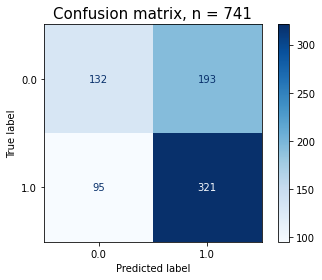

In [74]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

flg, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_opt, X_test, y_test,
                           cmap = plt.cm.Blues,
                           ax = ax);

plt.title(f"Confusion matrix, n = {len(y_test)}", fontsize = 15)
plt.show()

In [75]:
pipe_opt.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [76]:
def vaa_score(df):
    df["close_1y_lag"] = df["close"].shift(252)
    df["close_6m_lag"] = df["close"].shift(121)
    df["close_3m_lag"] = df["close"].shift(60)
    
    df["momentum_1y"] = (df["close"] - df["close_1y_lag"]) - 1
    df["momentum_6m"] = (df["close"] - df["close_6m_lag"]) - 1
    df["momentum_3m"] = (df["close"] - df["close_3m_lag"]) - 1
    
    df["vaa_score"] = (12 * df["momentum_20"]) + (4 * df["momentum_3m"]) + (2 * df["momentum_6m"]) + (1 * df["momentum_1y"])
    
    return df

In [78]:
wti_vaa = vaa_score(wti_etf)

In [79]:
wti_result = wti_vaa[wti_vaa["date"] >= "2018-01-01"][["date", "change", "vaa_score"]].reset_index(drop = True)
wti_result = pd.merge(wti_result, wti_etf_f["date"], on = "date", how = "inner")
wti_result["predict"] = pipe_opt.predict(X_test)
wti_result

,date,change,vaa_score,predict
0,2018-01-02,0.016129,3353.660287,0.0
1,2018-01-03,-0.006803,2953.529201,0.0
2,2018-01-04,0.028539,3908.840855,0.0
3,2018-01-05,-0.003330,3713.889952,0.0
4,2018-01-08,-0.004454,3623.847904,0.0
...,...,...,...,...
736,2021-02-01,0.006383,1143.755056,1.0
737,2021-02-02,0.031712,1444.650350,1.0
738,2021-02-03,0.012295,1599.144124,1.0
739,2021-02-04,0.022267,2044.202614,1.0


In [80]:
wti_result.to_csv("wti_result.csv")